End-to-End Supervised Learning Project!

# **PROJECT:** Analysis of New York City's Energy and Water Data Using Linear Learner Model on Amazon SageMaker



# Contents

1. Introduction
2. Data Setup
3. Data Preparation/Preprocessing
4. Training the model
5. Batch Transformation for Offline Inferences
6. DataCapture Configuration, and Model deployment for Real-time inferences
7. Model Monitoring
8. Clean up

# Introduction

This Notebook uses Linear Learner algorithm on Amazon Sagemaker to train, host, maintain a regression model. The data used were obtained from NYC OpenData Portal 

# Setup

This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.

# Dataset and Data Ingestion

In [1]:
# Importing Libraries

# Data processing

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Visualization

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning

from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn.feature_selection as fs
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn.metrics as metrics
from sklearn.datasets import *
import sklearn.model_selection
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import xgboost
from xgboost import XGBRegressor

# SageMaker

from time import sleep
import boto3
import sagemaker
import s3fs
import os
from time import sleep, gmtime, strftime
import json
import sys
import subprocess
import pkg_resources
import io
from urllib.parse import urlparse

# SageMaker Experiment

import time
from time import strftime

#!pip install sagemaker-experiments --> if it isn't installed.
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker


In [2]:
# To ensure the latest sagemaker is been used.

import sagemaker
print(sagemaker.__version__)

2.46.1


In [3]:
data_bucket = 'just-abdul-aws' #Defining bucket name
subfolder = 'NewYork' #Defining sub-folder name
dataset = '2018.csv'

In [4]:
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
s3 = s3fs.S3FileSystem(anon=False)
sm = boto3.Session().client('sagemaker')

In [5]:
df = pd.read_csv(f's3://{data_bucket}/{subfolder}/{dataset}')

# Understanding the data

In [6]:
df.head(5)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,City Building,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self - reported",NYC Building Identification Number (BIN),Address 1 (self - reported),...,Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²),Water Required?,Generation Date,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,7365,1155,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1009970029,1009970029,1022631,1155 Avenue of the Americas,...,Not Available,Not Available,No,04/30/2019 11:53:26 AM,40.756631,-73.982826,105.0,4.0,119,Midtown-Midtown South
1,2,8139,200,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1013150001,1013150001,1037545,200 East 42nd St.,...,7252.6,18.87,Yes,04/30/2019 11:53:27 AM,NaN,NaN,NaN,NaN,NaN,NaN
2,3,8604,114,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1009990019,1009990019,1022667,114 West 47th st,...,Not Available,Not Available,No,04/30/2019 11:53:27 AM,NaN,NaN,NaN,NaN,NaN,NaN
3,4,8841,733,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1013190047,1013190047,1037596,733 Third Avenue,...,Not Available,Not Available,No,04/30/2019 11:53:27 AM,40.753074,-73.972753,106.0,4.0,90,Turtle Bay-East Midtown
4,5,11809,Conde Nast Building,Not Applicable: Standalone Property,Not Applicable: Standalone Property,No,1009950005,1009950005,1085682,4 Times Square,...,Not Available,Not Available,NaN,04/30/2019 11:53:27 AM,40.756181,-73.986244,105.0,4.0,119,Midtown-Midtown South


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25939 entries, 0 to 25938
Data columns (total 67 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Order                                                       25939 non-null  object 
 1   Property Id                                                 25939 non-null  int64  
 2   Property Name                                               25939 non-null  object 
 3   Parent Property Id                                          25939 non-null  object 
 4   Parent Property Name                                        25939 non-null  object 
 5   City Building                                               25939 non-null  object 
 6   BBL - 10 digits                                             25939 non-null  object 
 7   NYC Borough, Block and Lot (BBL) self - reported            25939 non-null  object 
 

In [8]:
df.describe()

,Property Id,Postcode,Number of Buildings,Occupancy,Latitude,Longitude,Community Board,Council District
count,2.593900e+04,2.589200e+04,25939.000000,25939.000000,16834.000000,16834.000000,16834.000000,16834.000000
mean,5.045627e+06,1.842241e+05,1.240063,98.164347,40.742200,-73.928984,264.651123,22.439408
std,1.804315e+06,4.311858e+06,3.430990,9.459872,0.080676,0.069150,114.613441,14.463578
min,7.365000e+03,1.222000e+03,0.000000,0.000000,40.509037,-74.244118,101.000000,1.000000
25%,3.111576e+06,1.002800e+04,1.000000,100.000000,40.685378,-73.975683,202.000000,10.000000
50%,5.950838e+06,1.046000e+04,1.000000,100.000000,40.738306,-73.932690,302.000000,21.000000
75%,6.631356e+06,1.122000e+04,1.000000,100.000000,40.815921,-73.889371,401.000000,35.000000
max,8.729534e+06,1.143423e+08,161.000000,100.000000,40.912869,-73.700935,503.000000,51.000000


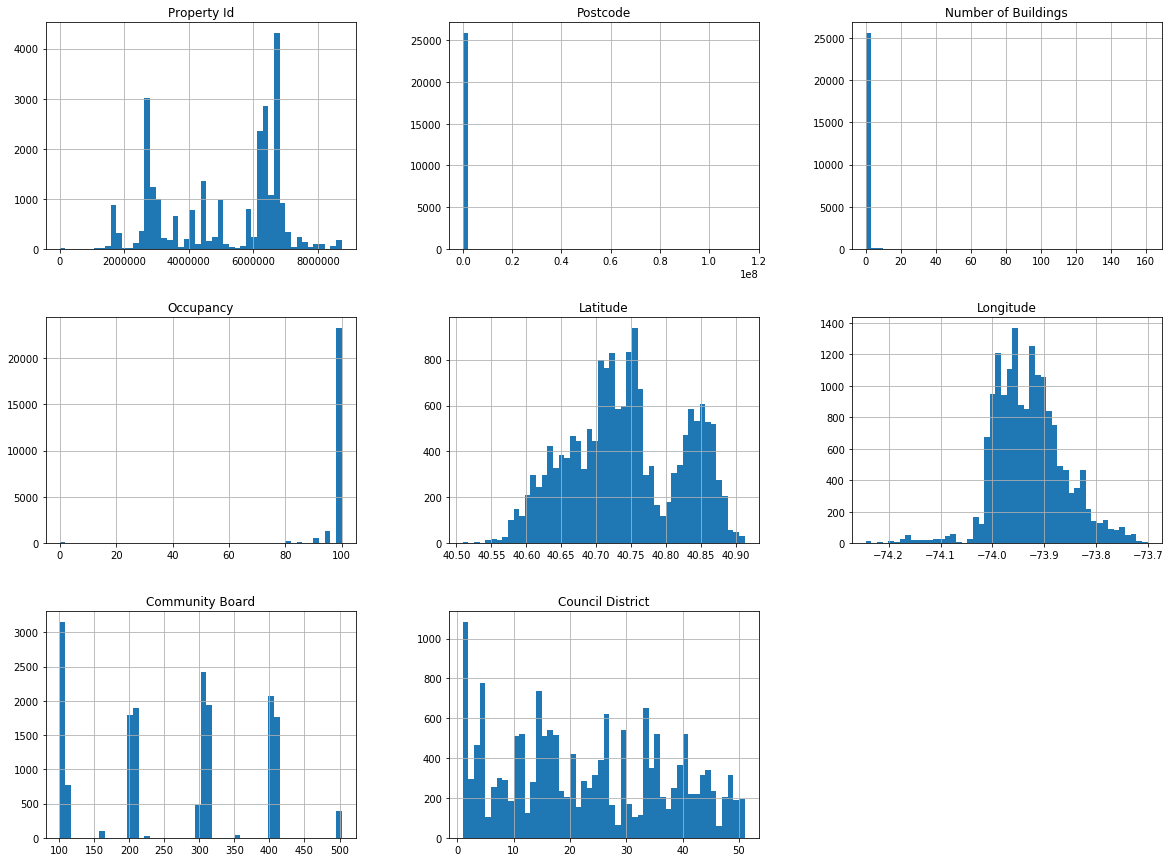

In [9]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Most of the data are in Categorical form, some features have no correlation nor add value to the target variable (Total GHG) thus need cleaning

# Data Cleaning/Preparation

In [10]:
df = df.replace('Not Available', None)

In [11]:
# Removing the character in the data.

df[['DOF Gross Floor Area  (ft²)', 'Year Built']] = df[['DOF Gross Floor Area  (ft²)', 'Year Built']].replace(',','', regex=True)

In [12]:
# Selecting Obj type which are actually numbers

cols = ['NYC Building Identification Number (BIN)','Postcode','DOF Gross Floor Area  (ft²)','Year Built','ENERGY STAR Score','Source EUI (kBtu/ft²)','Weather Normalized Site EUI (kBtu/ft²)','Site EUI (kBtu/ft²)','Weather Normalized Source EUI (kBtu/ft²)','Weather Normalized Site Electricity Intensity (kWh/ft²)','Weather Normalized Site Natural Gas Intensity (therms/ft²)','Natural Gas Use (kBtu)','Weather Normalized Site Natural Gas Use (therms)','Electricity Use - Grid Purchase (kWh)','Weather Normalized Site Electricity (kWh)','Total GHG Emissions (Metric Tons CO2e)','Direct GHG Emissions (Metric Tons CO2e)','Indirect GHG Emissions (Metric Tons CO2e)','Water Use (All Water Sources) (kgal)','Water Use Intensity (All Water Sources) (gal/ft²)']

In [13]:
# Selecting Obj type which are actually numbers

cols2 = ['BBL - 10 digits','Street Number', 'Self-Reported Gross Floor Area (ft²)','Largest Property Use Type - Gross Floor Area (ft²)','2nd Largest Property Use - Gross Floor Area (ft²)','3rd Largest Property Use Type - Gross Floor Area (ft²)','Fuel Oil #1 Use (kBtu)','Fuel Oil #2 Use (kBtu)','Fuel Oil #5 & 6 Use (kBtu)','Fuel Oil #2 Use (kBtu)','Diesel #2 Use (kBtu)','Propane Use (kBtu)','District Steam Use (kBtu)','District Chilled Water Use (kBtu)','Electricity Use - Grid Purchase (kBtu)','Annual Maximum Demand (kW)']

In [14]:
# Converting Obj type to Num

col = cols + cols2
df[col] = df[col].apply(pd.to_numeric, errors='coerce', axis=1)

In [15]:
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())

nulls = pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage']).sort_values(by='Sum', ascending=False).head(30)
nulls

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Sum,Percentage
Largest Property Use Type - Gross Floor Area (ft²),25936,0.999884
Self-Reported Gross Floor Area (ft²),25934,0.999807
Propane Use (kBtu),15939,0.614480
Longitude,9105,0.351016
Latitude,9105,0.351016
NTA,9105,0.351016
Community Board,9105,0.351016
Council District,9105,0.351016
Census Tract,9105,0.351016
DOF Gross Floor Area (ft²),6584,0.253826


A 30% missing value threshold is selected. columns with more than 30% missing values will be dropped.

In [16]:
#Selecting the columns with more than 30% missing values

remove = nulls[nulls['Percentage']>=0.30]
remove.index.name = 'Features' # Renames the index to 'Features'
remove.reset_index(level=0, inplace=True) # Re-index's the dataframe, turning 'Features' into a column
remove

,Features,Sum,Percentage
0,Largest Property Use Type - Gross Floor Area (...,25936,0.999884
1,Self-Reported Gross Floor Area (ft²),25934,0.999807
2,Propane Use (kBtu),15939,0.614480
3,Longitude,9105,0.351016
4,Latitude,9105,0.351016
5,NTA,9105,0.351016
6,Community Board,9105,0.351016
7,Council District,9105,0.351016
8,Census Tract,9105,0.351016


In [17]:
remove['Features'].tolist()

['Largest Property Use Type - Gross Floor Area (ft²)',
 'Self-Reported Gross Floor Area (ft²)',
 'Propane Use (kBtu)',
 'Longitude',
 'Latitude',
 'NTA',
 'Community Board',
 'Council District',
 'Census Tract']

In [18]:
#Dropping the columns with more than 30% missing values

df = df.drop(remove['Features'].tolist(), axis=1)

In [19]:
# Dropping other columns that aren't useful

df = df.drop(['Order','Property Name', 'Parent Property Id','Parent Property Name', 'Property Id','BBL - 10 digits','NYC Building Identification Number (BIN)','Postcode','Street Number', 'NYC Borough, Block and Lot (BBL) self - reported','Address 1 (self - reported)','Water Required?', 'Address 2 (self - reported)','Street Name','Fuel Oil #4 Use (kBtu)','Kerosene Use (kBtu)', 'Annual Maximum Demand (MM/YYYY)', 'Generation Date','District Hot Water Use (kBtu)'], axis=1)

In [20]:
df_obj = df.select_dtypes(include=['object'])
df_num = df.select_dtypes(exclude=['object'])

In [21]:
df_num

,DOF Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),...,Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Annual Maximum Demand (kW),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²)
0,734668.0,5227.0,NaN,1982.0,1,40,79.0,110.9,110.9,45.7,...,NaN,23995341.5,7032631.5,7032631.5,NaN,2520.9,0.0,2520.9,NaN,NaN
1,380000.0,15789.0,2115.0,1956.0,1,100,62.0,193.4,190.6,101.0,...,NaN,17308898.1,5072947.2,5055495.0,NaN,2895.1,0.0,2895.1,7252.6,18.87
2,646995.0,15789.0,2115.0,1989.0,1,95,66.0,155.6,154.6,70.3,...,9632.3,25783057.2,7556580.9,7446568.4,NaN,3155.8,51.2,3104.7,7252.6,18.87
3,405399.0,15789.0,2115.0,1961.0,1,100,64.0,181.5,178.2,97.1,...,9632.3,15906223.2,4661846.8,4612102.7,NaN,2826.2,0.0,2826.2,7252.6,18.87
4,NaN,62864.0,2115.0,1999.0,1,100,42.0,226.1,227.3,100.4,...,389906.7,109258703.4,32021890.4,32021890.4,NaN,12179.3,1991.7,10187.6,7252.6,18.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25934,375225.0,9980.0,8510.0,1972.0,1,75,100.0,20.4,20.4,19.4,...,36466.0,821766.1,240845.8,240845.8,0.0,193.7,193.7,0.0,294.2,8.93
25935,375225.0,9980.0,8510.0,1973.0,2,75,27.0,134.7,133.0,86.0,...,228877.1,9519753.3,2790079.8,2709471.4,687.8,2014.0,1207.8,806.2,18450.8,49.17
25936,27424.0,9980.0,8510.0,2015.0,1,90,6.0,219.7,218.5,107.1,...,12557.0,1680788.6,492610.9,489166.9,687.8,209.0,66.7,142.3,2675.8,97.57
25937,43073.0,9980.0,8510.0,1900.0,1,100,6.0,219.7,218.5,107.1,...,12557.0,686541.0,201213.6,201213.6,687.8,209.0,66.7,58.1,10.5,0.24


# Dealing with NaN values.

Nan values will be replaced with the median of that feature/column

In [22]:
# Creating a pipeline that handles NaNs as well as transforms data using standard scaler.

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median"))])

In [23]:
df_pipeline = num_pipeline.fit_transform(df_num)

In [24]:
df_pipe = pd.DataFrame(df_pipeline, columns=df_num.columns,index=df_num.index)

In [25]:
df_pipe

,DOF Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings,Occupancy,ENERGY STAR Score,Source EUI (kBtu/ft²),Weather Normalized Source EUI (kBtu/ft²),Site EUI (kBtu/ft²),...,Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Electricity Use - Grid Purchase (kWh),Weather Normalized Site Electricity (kWh),Annual Maximum Demand (kW),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Use Intensity (All Water Sources) (gal/ft²)
0,734668.0,5227.0,5712.0,1982.0,1.0,40.0,79.0,110.9,110.9,45.7,...,30269.4,23995341.5,7032631.5,7032631.5,152.0,2520.9,0.0,2520.9,3242.1,49.17
1,380000.0,15789.0,2115.0,1956.0,1.0,100.0,62.0,193.4,190.6,101.0,...,30269.4,17308898.1,5072947.2,5055495.0,152.0,2895.1,0.0,2895.1,7252.6,18.87
2,646995.0,15789.0,2115.0,1989.0,1.0,95.0,66.0,155.6,154.6,70.3,...,9632.3,25783057.2,7556580.9,7446568.4,152.0,3155.8,51.2,3104.7,7252.6,18.87
3,405399.0,15789.0,2115.0,1961.0,1.0,100.0,64.0,181.5,178.2,97.1,...,9632.3,15906223.2,4661846.8,4612102.7,152.0,2826.2,0.0,2826.2,7252.6,18.87
4,56986.0,62864.0,2115.0,1999.0,1.0,100.0,42.0,226.1,227.3,100.4,...,389906.7,109258703.4,32021890.4,32021890.4,152.0,12179.3,1991.7,10187.6,7252.6,18.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25934,375225.0,9980.0,8510.0,1972.0,1.0,75.0,100.0,20.4,20.4,19.4,...,36466.0,821766.1,240845.8,240845.8,0.0,193.7,193.7,0.0,294.2,8.93
25935,375225.0,9980.0,8510.0,1973.0,2.0,75.0,27.0,134.7,133.0,86.0,...,228877.1,9519753.3,2790079.8,2709471.4,687.8,2014.0,1207.8,806.2,18450.8,49.17
25936,27424.0,9980.0,8510.0,2015.0,1.0,90.0,6.0,219.7,218.5,107.1,...,12557.0,1680788.6,492610.9,489166.9,687.8,209.0,66.7,142.3,2675.8,97.57
25937,43073.0,9980.0,8510.0,1900.0,1.0,100.0,6.0,219.7,218.5,107.1,...,12557.0,686541.0,201213.6,201213.6,687.8,209.0,66.7,58.1,10.5,0.24


# Dealing with Cat datatype

In [26]:
le=LabelEncoder()

for col in df_obj.columns.values:
    # Encoding only categorical variables
    if df_obj[col].dtypes=='object':
        # Using whole data to form an exhaustive list of levels
        data=df_obj[col]
        le.fit(data.values)
        df_obj[col]=le.transform(df_obj[col])

In [27]:
df_obj

,City Building,Borough,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,2nd Largest Property Use Type,3rd Largest Property Use Type,Metered Areas (Energy),Metered Areas (Water)
0,0,2,33,86,32,2,24,8,2
1,0,2,33,97,32,50,2,8,5
2,0,2,13,325,13,50,2,8,5
3,0,2,33,889,32,50,2,8,5
4,0,2,33,973,32,50,2,8,5
...,...,...,...,...,...,...,...,...,...
25934,0,0,30,679,29,29,25,8,5
25935,0,0,30,679,29,29,25,8,5
25936,0,1,19,478,19,29,25,8,5
25937,0,2,30,679,29,29,25,8,5


In [28]:
df_cleaned = pd.concat([df_pipe,df_obj], axis =1)

In [29]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25939 entries, 0 to 25938
Data columns (total 39 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   DOF Gross Floor Area  (ft²)                                 25939 non-null  float64
 1   2nd Largest Property Use - Gross Floor Area (ft²)           25939 non-null  float64
 2   3rd Largest Property Use Type - Gross Floor Area (ft²)      25939 non-null  float64
 3   Year Built                                                  25939 non-null  float64
 4   Number of Buildings                                         25939 non-null  float64
 5   Occupancy                                                   25939 non-null  float64
 6   ENERGY STAR Score                                           25939 non-null  float64
 7   Source EUI (kBtu/ft²)                                       25939 non-null  float64
 

# Feature Selection

In [30]:
# Selecting features and the target variable

Y_selection = df_cleaned['Total GHG Emissions (Metric Tons CO2e)']  #Target Feature
X_selection = df_cleaned.drop("Total GHG Emissions (Metric Tons CO2e)", 1)

In [31]:
# Partitioning the dataset into 2/3 training and 1/3 test set.
X_train_selection, X_test_selection, Y_train_selection, Y_test_selection = sklearn.model_selection.train_test_split(X_selection, Y_selection, test_size=0.33)

# Further splitting the training set into a validation set; 2/3 training set, and 1/3 validation set
X_train_selection, X_val_selection, Y_train_selection, Y_val_selection = sklearn.model_selection.train_test_split(X_train_selection, Y_train_selection, test_size=0.33)

In [32]:
# Feature Selection using XGBRegressor

X_data, y_label = make_regression(
    n_samples=X_train_selection.shape[0], n_features=X_train_selection.shape[1], n_informative=10, random_state=1
)
xgboost_model = XGBRegressor()
xgboost_model.fit(X_data, y_label)

feature_scores = []
feature_importances_xgboost = xgboost_model.feature_importances_
for index, importance_score in enumerate(feature_importances_xgboost):
    feature_scores.append([X_train_selection.columns[index], importance_score])

In [33]:
# List of features and their respective scores, depicting their importance

sorted_scores = sorted(np.array(feature_scores), key=lambda s: float(s[1]), reverse=True) 
print(np.array(sorted_scores))

[['Weather Normalized Site Electricity (kWh)' '0.17540875']
 ['Site EUI (kBtu/ft²)' '0.1368753']
 ['3rd Largest Property Use Type' '0.1244295']
 ['Indirect GHG Emissions (Metric Tons CO2e)' '0.12201577']
 ['Largest Property Use Type' '0.12166264']
 ['Fuel Oil #5 & 6 Use (kBtu)' '0.09345414']
 ['DOF Gross Floor Area  (ft²)' '0.06590423']
 ['3rd Largest Property Use Type - Gross Floor Area (ft²)' '0.059950735']
 ['List of All Property Use Types at Property' '0.057724368']
 ['Diesel #2 Use (kBtu)' '0.0021826986']
 ['Direct GHG Emissions (Metric Tons CO2e)' '0.0020963778']
 ['Electricity Use - Grid Purchase (kBtu)' '0.0019719838']
 ['2nd Largest Property Use Type' '0.0018877045']
 ['Primary Property Type - Self Selected' '0.0017099641']
 ['Natural Gas Use (kBtu)' '0.0016801067']
 ['Metered Areas (Energy)' '0.001636952']
 ['Weather Normalized Site Natural Gas Use (therms)' '0.0015644416']
 ['Weather Normalized Site Natural Gas Intensity (therms/ft²)'
  '0.0015633831']
 ['Fuel Oil #2 Use (kB

In [34]:
features = pd.DataFrame(feature_scores, columns=['Features','Score'])
features.sort_values(by='Score', ascending=False).head(15)

,Features,Score
23,Weather Normalized Site Electricity (kWh),0.175409
9,Site EUI (kBtu/ft²),0.136875
35,3rd Largest Property Use Type,0.124430
26,Indirect GHG Emissions (Metric Tons CO2e),0.122016
33,Largest Property Use Type,0.121663
15,Fuel Oil #5 & 6 Use (kBtu),0.093454
0,DOF Gross Floor Area (ft²),0.065904
2,3rd Largest Property Use Type - Gross Floor Ar...,0.059951
32,List of All Property Use Types at Property,0.057724
16,Diesel #2 Use (kBtu),0.002183


In [35]:
# Setting a score threshold of 0.002

Top_features = features[features['Score']>=0.002]
Top_features

,Features,Score
0,DOF Gross Floor Area (ft²),0.065904
2,3rd Largest Property Use Type - Gross Floor Ar...,0.059951
9,Site EUI (kBtu/ft²),0.136875
15,Fuel Oil #5 & 6 Use (kBtu),0.093454
16,Diesel #2 Use (kBtu),0.002183
23,Weather Normalized Site Electricity (kWh),0.175409
25,Direct GHG Emissions (Metric Tons CO2e),0.002096
26,Indirect GHG Emissions (Metric Tons CO2e),0.122016
32,List of All Property Use Types at Property,0.057724
33,Largest Property Use Type,0.121663


In [36]:
# List of Top features

Top_features['Features'].tolist()

['DOF Gross Floor Area  (ft²)',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)',
 'Site EUI (kBtu/ft²)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'Weather Normalized Site Electricity (kWh)',
 'Direct GHG Emissions (Metric Tons CO2e)',
 'Indirect GHG Emissions (Metric Tons CO2e)',
 'List of All Property Use Types at Property',
 'Largest Property Use Type',
 '3rd Largest Property Use Type']

# Checking for Multi-Collinearity

In [37]:
# VIF = 1, indicates no correlation between the independent variable and the other variables 
# VIF exceeding 5 or 10 indicates high multicollinearity between the independent variable and the others

def calc_vif(C):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = C.columns
    vif["VIF"] = [variance_inflation_factor(C.values, i) for i in range(C.shape[1])]

    return(vif)

In [38]:
X_selection[Top_features['Features'].tolist()]

,DOF Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Site EUI (kBtu/ft²),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Weather Normalized Site Electricity (kWh),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),List of All Property Use Types at Property,Largest Property Use Type,3rd Largest Property Use Type
0,734668.0,5712.0,45.7,2882919.0,69000.0,7032631.5,0.0,2520.9,86,32,24
1,380000.0,2115.0,101.0,2882919.0,69000.0,5055495.0,0.0,2895.1,97,32,2
2,646995.0,2115.0,70.3,2882919.0,69000.0,7446568.4,51.2,3104.7,325,13,2
3,405399.0,2115.0,97.1,2882919.0,69000.0,4612102.7,0.0,2826.2,889,32,2
4,56986.0,2115.0,100.4,2882919.0,69000.0,32021890.4,1991.7,10187.6,973,32,2
...,...,...,...,...,...,...,...,...,...,...,...
25934,375225.0,8510.0,19.4,478984.5,14322605.8,240845.8,193.7,0.0,679,29,25
25935,375225.0,8510.0,86.0,478984.5,14322605.8,2709471.4,1207.8,806.2,679,29,25
25936,27424.0,8510.0,107.1,478984.5,14322605.8,489166.9,66.7,142.3,478,19,25
25937,43073.0,8510.0,107.1,478984.5,14322605.8,201213.6,66.7,58.1,679,29,25


In [39]:
C = X_selection[Top_features['Features'].tolist()].iloc[:,:]
calc_vif(C)

,variables,VIF
0,DOF Gross Floor Area (ft²),1.432119
1,3rd Largest Property Use Type - Gross Floor Ar...,1.219515
2,Site EUI (kBtu/ft²),5.524459
3,Fuel Oil #5 & 6 Use (kBtu),1.477446
4,Diesel #2 Use (kBtu),1.239906
5,Weather Normalized Site Electricity (kWh),1.483562
6,Direct GHG Emissions (Metric Tons CO2e),1.193485
7,Indirect GHG Emissions (Metric Tons CO2e),5.494043
8,List of All Property Use Types at Property,33.208199
9,Largest Property Use Type,29.140909


High Correlations found between:
    1) List of All Property Use Types at Property
    2) Largest Property Use Type
    3) 3rd Largest Property Use Type

In [40]:
# Uncorrellated top features

Top_feature = X_selection[['DOF Gross Floor Area  (ft²)',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)',
 'Site EUI (kBtu/ft²)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'Weather Normalized Site Electricity (kWh)',
 'Direct GHG Emissions (Metric Tons CO2e)',
 'Indirect GHG Emissions (Metric Tons CO2e)',
 'Largest Property Use Type']]

In [41]:
C = Top_feature.iloc[:,:]
calc_vif(C)

,variables,VIF
0,DOF Gross Floor Area (ft²),1.429931
1,3rd Largest Property Use Type - Gross Floor Ar...,1.215762
2,Site EUI (kBtu/ft²),5.522052
3,Fuel Oil #5 & 6 Use (kBtu),1.458902
4,Diesel #2 Use (kBtu),1.233801
5,Weather Normalized Site Electricity (kWh),1.467141
6,Direct GHG Emissions (Metric Tons CO2e),1.191741
7,Indirect GHG Emissions (Metric Tons CO2e),5.491215
8,Largest Property Use Type,1.911331


In [42]:
# No Correlation observed

selected_df = X_selection[['DOF Gross Floor Area  (ft²)',
 '3rd Largest Property Use Type - Gross Floor Area (ft²)',
 'Site EUI (kBtu/ft²)',
 'Fuel Oil #5 & 6 Use (kBtu)',
 'Diesel #2 Use (kBtu)',
 'Weather Normalized Site Electricity (kWh)',
 'Direct GHG Emissions (Metric Tons CO2e)',
 'Indirect GHG Emissions (Metric Tons CO2e)',
 'Largest Property Use Type']]

In [43]:
selected_df

,DOF Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Site EUI (kBtu/ft²),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),Weather Normalized Site Electricity (kWh),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Largest Property Use Type
0,734668.0,5712.0,45.7,2882919.0,69000.0,7032631.5,0.0,2520.9,32
1,380000.0,2115.0,101.0,2882919.0,69000.0,5055495.0,0.0,2895.1,32
2,646995.0,2115.0,70.3,2882919.0,69000.0,7446568.4,51.2,3104.7,13
3,405399.0,2115.0,97.1,2882919.0,69000.0,4612102.7,0.0,2826.2,32
4,56986.0,2115.0,100.4,2882919.0,69000.0,32021890.4,1991.7,10187.6,32
...,...,...,...,...,...,...,...,...,...
25934,375225.0,8510.0,19.4,478984.5,14322605.8,240845.8,193.7,0.0,29
25935,375225.0,8510.0,86.0,478984.5,14322605.8,2709471.4,1207.8,806.2,29
25936,27424.0,8510.0,107.1,478984.5,14322605.8,489166.9,66.7,142.3,19
25937,43073.0,8510.0,107.1,478984.5,14322605.8,201213.6,66.7,58.1,29


# Preparing data for Amazon SageMaker

In [44]:
X = selected_df
Y = df_cleaned['Total GHG Emissions (Metric Tons CO2e)']  #Target Feature

In [45]:
# Partitioning the dataset into 2/3 training and 1/3 test set.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33)

# Further splitting the training set into a validation set; 2/3 training set, and 1/3 validation set
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

For the Amazon SageMaker built-in XGBoost algorithm, the target feature column must be the first column in the dataframe.

In [46]:
train = pd.concat([Y_train, X_train], axis= 1)
val = pd.concat([Y_val, X_val], axis=1)
test = X_test

The 2017 and 2019 data have been cleaned using the preprocessing script, so they'd be imported from Amazon S3

In [47]:
dataset_2017 = 'cleaned_2017.csv'
dataset_2019 = 'cleaned_2019.csv'

In [48]:
data_2017 = pd.read_csv(f's3://{data_bucket}/{subfolder}/{dataset_2017}')
data_2019 = pd.read_csv(f's3://{data_bucket}/{subfolder}/{dataset_2019}')

In [49]:
data_2017 = data_2017.drop("Unnamed: 0", 1)
data_2019 = data_2019.drop("Unnamed: 0", 1)

In [51]:
#Preparing the 2017 and 2019 dataset for the model 

Y_2017 = data_2017['Total GHG Emissions (Metric Tons CO2e)'] # Target
X_2017 = data_2017.drop("Total GHG Emissions (Metric Tons CO2e)", 1)

Y_2019 = data_2019['Total GHG Emissions (Metric Tons CO2e)']  # Target
X_2019 = data_2019.drop("Total GHG Emissions (Metric Tons CO2e)", 1)

In [52]:
# Reducing the test sizes to 75%

X_train_2017, X_test_2017, Y_train_2017, Y_test_2017 = sklearn.model_selection.train_test_split(X_2017, Y_2017, test_size=0.75)
X_train_2019, X_test_2019, Y_train_2019, Y_test_2019 = sklearn.model_selection.train_test_split(X_2019, Y_2019, test_size=0.75)

# Converting Data to csv

In [53]:
train_file = train.to_csv(None, header=False, index=False).encode() # Doesn't include column header
train_file_header = train.to_csv(None, index=False).encode()
val_file = val.to_csv(None, header=False, index=False).encode() #Encode is to ensure text in csv is saved in the right format
test_file = test.to_csv(None, header=False, index=False).encode()
test_2017 = X_test_2017.to_csv(None, header=False, index=False).encode()
test_2019 = X_test_2019.to_csv(None, header=False, index=False).encode()

# Saving the CSV files to S3

In [54]:
with s3.open(f'{data_bucket}/{subfolder}/processed/train.csv', 'wb') as f:
    f.write(train_file)
with s3.open(f'{data_bucket}/{subfolder}/train_headers/train_data_with_headers.csv', 'wb') as f:
    f.write(train_file_header)
with s3.open(f'{data_bucket}/{subfolder}/processed/val.csv', 'wb') as f:
    f.write(val_file)
with s3.open(f'{data_bucket}/{subfolder}/processed/test.csv', 'wb') as f:
    f.write(test_file)
with s3.open(f'{data_bucket}/{subfolder}/processed/test_2017.csv', 'wb') as f:
    f.write(test_2017)
with s3.open(f'{data_bucket}/{subfolder}/processed/test_2019.csv', 'wb') as f:
    f.write(test_2019)

# File Location

In [55]:
raw_data_location = f's3://{data_bucket}/{subfolder}/{dataset}'
train_location = f's3://{data_bucket}/{subfolder}/processed/train.csv'
train_header_location = f's3://{data_bucket}/{subfolder}/train_headers/train_data_with_headers.csv'
val_location = f's3://{data_bucket}/{subfolder}/processed/val.csv'
test_location = f's3://{data_bucket}/{subfolder}/processed/test.csv'
test_2017_location = f's3://{data_bucket}/{subfolder}/processed/test_2017.csv'
test_2019_location = f's3://{data_bucket}/{subfolder}/processed/test_2019.csv'

# Preparing the CSV data for SageMaker

In [56]:
input_train = sagemaker.TrainingInput(s3_data=train_location, content_type="text/csv")
input_validation = sagemaker.TrainingInput(s3_data=val_location, content_type="text/csv")

In [57]:
# Copies test dataset from Amazon S3 into local folder.  

test_sample_path = test_2019_location
! aws s3 cp $test_sample_path .

download: s3://just-abdul-aws/NewYork/processed/test_2019.csv to ./test_2019.csv


# Creating SageMaker Experiment

Sagemaker experiment helps track preprocessing and training changes

In [58]:
# Create a SageMaker Experiment

create_date = strftime("%Y-%m-%d-%H-%M-%S")
LL_experiment = Experiment.create(experiment_name = "LL-Build-train-deploy-{}".format(create_date),
                                    description = "Predict GHG Emission from Energy and Water data",
                                   sagemaker_boto_client=sm,
                                    tags = [{'Key': 'LL-experiments', 'Value': 'NYC'}])
print(LL_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f347d53c0d0>,experiment_name='LL-Build-train-deploy-2021-06-26-07-32-29',description='Predict GHG Emission from Energy and Water data',tags=[{'Key': 'LL-experiments', 'Value': 'NYC'}],experiment_arn='arn:aws:sagemaker:us-east-2:077107849065:experiment/ll-build-train-deploy-2021-06-26-07-32-29',response_metadata={'RequestId': '37c28d59-51c6-488d-9e96-0a517e2b9c93', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '37c28d59-51c6-488d-9e96-0a517e2b9c93', 'content-type': 'application/x-amz-json-1.1', 'content-length': '113', 'date': 'Sat, 26 Jun 2021 07:32:28 GMT'}, 'RetryAttempts': 0})


In [59]:
# Start Tracking parameters used in the Pre-processing pipeline.

with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({"train_test_split_ratio": 0.333, "random_state":0})
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="ccdefault-raw-dataset", media_type="s3/uri", value=raw_data_location)
    tracker.log_input(name="ccdefault-train-header-dataset", media_type="s3/uri", value=train_header_location)
    tracker.log_input(name="ccdefault-train-dataset", media_type="s3/uri", value=train_location)
    tracker.log_input(name="ccdefault-val-dataset", media_type="s3/uri", value=val_location)
    tracker.log_input(name="ccdefault-test-dataset", media_type="s3/uri", value=test_location)
    tracker.log_input(name="ccdefault-test2017-dataset", media_type="s3/uri", value=test_2017_location)
    tracker.log_input(name="ccdefault-test2019-dataset", media_type="s3/uri", value=test_2019_location)

# Training the Model

In [ ]:
sess = sagemaker.Session()
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'linear-learner', 'latest')

# Tracking/Monitoring
preprocessing_trial_component = tracker.trial_component

trial_name = "NewYork-Training-job-{}".format(create_date)
Linear_trial = Trial.create(trial_name=trial_name, experiment_name=LL_experiment.experiment_name)

Linear_trial.add_trial_component(preprocessing_trial_component)
Linear_training_job_name = "NewYork-Training-job-{}".format(create_date)



Linear_Model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.large",
    output_path= f's3://{data_bucket}/{subfolder}/newmodel',
    sagemaker_session=sess)

# Setting-up Hyperparameter

Linear_Model.set_hyperparameters(
    feature_dim=X_train.shape[1], 
    predictor_type="regressor", 
    mini_batch_size=100
    )
    
Linear_Model.fit({"train": input_train, "validation": input_validation}, wait=True, job_name=Linear_training_job_name,  
         experiment_config={"TrialName": Linear_trial.trial_name, #log training job in Trials for lineage
            "TrialComponentDisplayName": "Training"}) 

# Batch Transform for offline inference

In [61]:
%%time

Linear_transformer = Linear_Model.transformer(instance_count = 1, instance_type = 'ml.m5.large', accept = 'text/csv')

INFO:sagemaker:Creating model with name: linear-learner-2021-06-26-07-38-12-600


CPU times: user 21.7 ms, sys: 0 ns, total: 21.7 ms
Wall time: 394 ms


In [ ]:
%%time

Linear_transformer.transform(test_location, split_type='Line', content_type='text/csv')

In [ ]:
Linear_transformer.wait()

In [64]:
# Specify's the batch output location

data_dir =  f's3://{data_bucket}/{subfolder}/processed/'

!aws s3 cp --recursive $Linear_transformer.output_path $data_dir

copy: s3://sagemaker-us-east-2-077107849065/linear-learner-2021-06-26-07-38-13-001/test.csv.out to s3://just-abdul-aws/NewYork/processed/test.csv.out


# Reviewing Batch Transform Output

In [65]:
# Function to access the batch transform result

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')
pred = get_csv_output_from_s3(Linear_transformer.output_path, 'test.csv.out')
pred = pd.read_csv(io.StringIO(pred), sep=",", header=None)
pred

,0
0,569.815125
1,2471.048096
2,508.671387
3,167.366013
4,261.943848
...,...
8555,63.372627
8556,935.438354
8557,6.237604
8558,389.995972


In [68]:
pred.columns = ['Prediction'] # Renaming the column
pred['Prediction'] = pred.Prediction.str.replace(r"[a-zA-Z]",'') # Removing the str.
pred['Prediction'] = pred.Prediction.str.replace(r'[{}\""\:]','') # Removing Special Character
pred['Prediction'] = pred['Prediction'].apply(pd.to_numeric)
pred

,Prediction
0,569.815125
1,2471.048096
2,508.671387
3,167.366013
4,261.943848
...,...
8555,63.372627
8556,935.438354
8557,6.237604
8558,389.995972


In [69]:
test_mae_linear = np.mean(np.abs(Y_test - pred['Prediction'].tolist()))
test_mae_baseline = np.mean(np.abs(Y_test - np.median(Y_train)))  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 1461.564
Test MAE Linear: 102.206


In [70]:
actual = Y_test
actual = actual.reset_index(drop=True)

In [71]:
model_result = pd.concat([pred,actual], axis=1)
model_result

,Prediction,Total GHG Emissions (Metric Tons CO2e)
0,569.815125,557.8
1,2471.048096,2542.9
2,508.671387,504.9
3,167.366013,198.3
4,261.943848,271.6
...,...,...
8555,63.372627,74.2
8556,935.438354,933.8
8557,6.237604,27.2
8558,389.995972,433.9


In [63]:
# The Trained Model

from time import gmtime, strftime
from sagemaker.model import Model
from sagemaker.image_uris import retrieve

model_name = "Linear-Learner-Model-Monitor-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = "s3://just-abdul-aws/NewYork/newmodel/linear-learner-2021-06-23-07-35-44-219/output/model.tar.gz"


image_uri = retrieve("linear-learner", boto3.Session().region_name, "latest")

model = Model(image_uri=image_uri, model_data=model_url, role=role)


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


# Retrieve real-time inference data (results) from endpoints

# Configuring datacapture to capture 100% of the inference payloads received by the endpoint and deploying the model

In [72]:
from sagemaker.model_monitor import DataCaptureConfig

s3_capture_upload_path = 's3://{}/{}/monitoring/newDC/datacapture'.format(data_bucket, subfolder)

endpoint_name = "LL-model-monitor-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("EndpointName={}".format(endpoint_name))

data_capture_config = DataCaptureConfig(
    enable_capture=True, 
    sampling_percentage=100, 
    destination_s3_uri=s3_capture_upload_path, 
    capture_options = ["REQUEST"]

)

# Deploying the Model

predictor = Linear_Model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)

INFO:sagemaker:Creating model with name: linear-learner-2021-06-26-07-49-39-583


EndpointName=LL-model-monitor-2021-06-26-07-49-39


INFO:sagemaker:Creating endpoint with name LL-model-monitor-2021-06-26-07-49-39


---------------!

In [73]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
import time

predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

In [74]:
# Invoke Endpoint to capture results based on the test-data sent to the Model 

runtime_client = boto3.client('sagemaker-runtime')


with s3.open(f'{data_bucket}/{subfolder}/processed/test.csv') as f:
    payload = f.read().strip()
    response = runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="text/csv", Body=payload
)
result = json.loads(response["Body"].read().decode())
Y_pred = np.array([r["score"] for r in result["predictions"]])

In [75]:
Y_pred = pd.DataFrame(Y_pred)
Y_pred.columns=['Prediction']

In [76]:
test_mae_linear = np.mean(np.abs(Y_test - Y_pred['Prediction'].tolist()))
test_mae_baseline = np.mean(np.abs(Y_test - np.median(Y_train)))  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 1461.564
Test MAE Linear: 102.206


# Testing the Model on the 2019 data

In [77]:
%%time
from itertools import islice
import math
import struct
import boto3

runtime_client = boto3.client('sagemaker-runtime')


with s3.open(f'{data_bucket}/{subfolder}/processed/test_2019.csv') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint, ContentType="text/csv", Body=payload
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


CPU times: user 40.5 ms, sys: 7.38 ms, total: 47.9 ms
Wall time: 477 ms


In [78]:
result_2019 = json.loads(response["Body"].read().decode())
pred_2019 = np.array([r["score"] for r in result_2019["predictions"]])

pred_2019 = pd.DataFrame(pred_2019)
pred_2019.columns=['Prediction']

#Evaluating the model on the 2019 data
test_mae_linear = np.mean(np.abs(Y_test_2019 - pred_2019['Prediction'].tolist()))
test_mae_baseline = np.mean(np.abs(Y_test_2019 - np.median(Y_train_2019)))  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 586.107
Test MAE Linear: 182.055


In [79]:
actual_2019 = Y_test_2019
actual_2019 = actual_2019.reset_index(drop=True)

In [80]:
result_2019 = pd.concat([pred_2019,actual_2019], axis=1)
result_2019

,Prediction,Total GHG Emissions (Metric Tons CO2e)
0,487.402191,481.4
1,355.717224,335.7
2,1151.969971,1126.0
3,448.382568,453.7
4,43.560131,0.0
...,...,...
20830,1807.272461,1185.5
20831,146.661255,153.8
20832,365.344299,289.0
20833,171.194366,186.9


# Testing the Model on the 2017 data

In [81]:
%%time
from itertools import islice
import math
import struct
import boto3

runtime_client = boto3.client('sagemaker-runtime')


with s3.open(f'{data_bucket}/{subfolder}/processed/test_2017.csv') as f:
    payload = f.read().strip()
response = runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name, ContentType="text/csv", Body=payload
)

CPU times: user 42.2 ms, sys: 4.48 ms, total: 46.7 ms
Wall time: 547 ms


In [82]:
result_2017 = json.loads(response["Body"].read().decode())
pred_2017 = np.array([r["score"] for r in result_2017["predictions"]])

pred_2017 = pd.DataFrame(pred_2017)
pred_2017.columns=['Prediction']

# Evaluating the model on the 2017 data
test_mae_linear = np.mean(np.abs(Y_test_2017 - pred_2017['Prediction'].tolist()))
test_mae_baseline = np.mean(np.abs(Y_test_2017 - np.median(Y_train_2017)))  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 146.415
Test MAE Linear: 23971018.269


In [83]:
actual_2017 = Y_test_2017
actual_2017 = actual_2017.reset_index(drop=True)

In [84]:
result_2017 = pd.concat([pred_2017,actual_2017], axis=1)
result_2017

,Prediction,Total GHG Emissions (Metric Tons CO2e)
0,4.485686e+05,506.8
1,4.053576e+06,280.3
2,8.780939e+05,230.9
3,3.448236e+06,311.8
4,4.845730e+06,798.5
...,...,...
26010,2.956354e+06,52.6
26011,1.166531e+07,706.6
26012,5.052904e+06,402.7
26013,4.856892e+06,446.5


The model performed very poorly against the 2017 dataset, this can be due to the differences in the features selected, some features in the 2017 dataset were not present in 2019 dataset and viceversa.

# Monitoring

# Verify that Model Monitor is correctly capturing the incoming data.

In [85]:
# Extract the captured json files.

data_capture_prefix = '{}/monitoring'.format(subfolder)
s3_client = boto3.Session().client('s3')
current_endpoint_capture_prefix = '{}/newDC/datacapture/{}/AllTraffic'.format(data_capture_prefix, endpoint_name)
print(current_endpoint_capture_prefix)
result = s3_client.list_objects(Bucket=data_bucket, Prefix=current_endpoint_capture_prefix)
capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]

NewYork/monitoring/newDC/datacapture/LL-model-monitor-2021-06-26-07-49-39/AllTraffic


In [86]:
def get_obj_body(obj_key):
    return s3_client.get_object(Bucket=data_bucket, Key=obj_key).get("Body").read().decode("utf-8")


capture_file = get_obj_body(capture_files[-1])
print(capture_file[:2000])

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"73313.0,3000.0,127.7,0.0,0.0,735124.4,352.1,205.7,10\n383934.0,7457.0,85.8,26012250.6,69000.0,4525183.6,0.0,2542.9,32\n69590.0,13857.0,95.1,6875249.5,602797.8,288079.3,418.0,86.9,29\n36200.0,0.0,67.5,522165.0,20492310.3,335426.6,101.3,96.9,32\n33922.0,6234.0,107.5,1755900.0,0.0,512746.2,13.0,258.5,32\n40916.0,23200.0,17.4,0.0,0.0,163325.3,7.7,48.2,29\n50170.0,5343.0,79.6,5086026.6,0.0,237512.7,167.7,71.0,29\n39600.0,61709.0,84.0,3965668.0,0.0,139499.3,151.2,40.5,29\n100500.0,5000.0,160.1,34074.0,14322605.8,709304.3,725.8,205.8,29\n56986.0,6200.0,64.7,0.0,602797.8,390923.5,493.3,117.0,29\n56986.0,30000.0,88.9,2882919.0,151800.0,1139029.0,233.3,331.7,21\n39750.0,29601.0,71.4,5040436.2,20492310.3,963999.8,6.7,278.6,50\n26225.0,9561.0,366.2,2739775.5,20492310.3,613946.6,397.6,179.4,29\n114003.0,0.0,84.5,3185641.4,33120.0,580300.3,571.0,171.8,29\n56986.0,0.0,72.8,8342250.2,67204.2,777382.4,248.5,233.0,2

In [ ]:
import json

print(json.dumps(json.loads(capture_file.split("\n")[0]), indent=2))

In [88]:
# Copy over the training dataset to Amazon S3 (if you already have it in Amazon S3, you could reuse it)
prefix = "NewYork/LL-ModelMonitor"
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f's3://{data_bucket}/{subfolder}/train_headers'
baseline_results_uri = "s3://{}/{}".format(data_bucket, baseline_results_prefix)
print("Baseline data uri: {}".format(baseline_data_uri))
print("Baseline results uri: {}".format(baseline_results_uri))

Baseline data uri: s3://just-abdul-aws/NewYork/train_headers
Baseline results uri: s3://just-abdul-aws/NewYork/LL-ModelMonitor/baselining/results


# A baseline job for Model Monitor to capture the statistics of the training data

In [ ]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor.dataset_format import DatasetFormat

my_default_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=3600,
)

my_default_monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri + "/train_data_with_headers.csv",
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True,
)

In [90]:
s3_client = boto3.Session().client("s3")
result = s3_client.list_objects(Bucket=data_bucket, Prefix=baseline_results_prefix)
report_files = [report_file.get("Key") for report_file in result.get("Contents")]
print("Found Files:")
print("\n ".join(report_files))

Found Files:
NewYork/LL-ModelMonitor/baselining/results/constraints.json
 NewYork/LL-ModelMonitor/baselining/results/statistics.json


# Explore the generated constraints and statistics

In [91]:
import pandas as pd

baseline_job = my_default_monitor.latest_baselining_job
schema_df = pd.io.json.json_normalize(baseline_job.baseline_statistics().body_dict["features"])
schema_df.head(10)

,name,inferred_type,numerical_statistics.common.num_present,numerical_statistics.common.num_missing,numerical_statistics.mean,numerical_statistics.sum,numerical_statistics.std_dev,numerical_statistics.min,numerical_statistics.max,numerical_statistics.distribution.kll.buckets,numerical_statistics.distribution.kll.sketch.parameters.c,numerical_statistics.distribution.kll.sketch.parameters.k,numerical_statistics.distribution.kll.sketch.data
0,Total GHG Emissions (Metric Tons CO2e),Fractional,11643,0,7.846720e+02,9.135936e+06,3.543853e+03,0.0,255266.2,"[{'lower_bound': 0.0, 'upper_bound': 25526.620...",0.64,2048.0,"[[64.0, 537.6, 512.8, 3134.0, 1912.8, 359.3, 7..."
1,DOF Gross Floor Area (ft?),Fractional,11643,0,1.052343e+05,1.225243e+09,2.647070e+05,25006.0,13435076.0,"[{'lower_bound': 25006.0, 'upper_bound': 13660...",0.64,2048.0,"[[51914.0, 64896.0, 97636.0, 311501.0, 56986.0..."
2,3rd Largest Property Use Type - Gross Floor Ar...,Fractional,11643,0,1.319773e+04,1.536612e+08,3.243838e+04,0.0,892545.0,"[{'lower_bound': 0.0, 'upper_bound': 89254.5, ...",0.64,2048.0,"[[6234.0, 3550.0, 10000.0, 12211.0, 30000.0, 0..."
3,Site EUI (kBtu/ft?),Fractional,11643,0,9.894273e+01,1.151990e+06,7.591152e+02,0.0,81057.5,"[{'lower_bound': 0.0, 'upper_bound': 8105.75, ...",0.64,2048.0,"[[14.6, 96.9, 89.2, 123.0, 71.2, 101.4, 63.9, ..."
4,Fuel Oil #5 & 6 Use (kBtu),Fractional,11643,0,4.377923e+06,5.097215e+10,6.219196e+06,0.0,62991290.6,"[{'lower_bound': 0.0, 'upper_bound': 6299129.0...",0.64,2048.0,"[[1755900.0, 374999.9, 26012250.6, 2882919.0, ..."
5,Diesel #2 Use (kBtu),Fractional,11643,0,4.756486e+06,5.537977e+10,1.118877e+07,0.0,120336347.0,"[{'lower_bound': 0.0, 'upper_bound': 12033634....",0.64,2048.0,"[[0.0, 602797.8, 69000.0, 151800.0, 151800.0, ..."
6,Weather Normalized Site Electricity (kWh),Fractional,11643,0,1.180632e+06,1.374610e+10,3.991467e+06,0.0,121990108.6,"[{'lower_bound': 0.0, 'upper_bound': 12199010....",0.64,2048.0,"[[219813.1, 282944.2, 429482.2, 4664864.2, 164..."
7,Direct GHG Emissions (Metric Tons CO2e),Fractional,11643,0,3.671790e+02,4.275065e+06,1.937453e+03,0.0,144497.3,"[{'lower_bound': 0.0, 'upper_bound': 14449.73,...",0.64,2048.0,"[[0.0, 346.3, 385.9, 0.0, 1438.0, 298.1, 305.9..."
8,Indirect GHG Emissions (Metric Tons CO2e),Fractional,11643,0,4.172567e+02,4.858120e+06,2.778816e+03,-281.1,255266.2,"[{'lower_bound': -281.1, 'upper_bound': 25273....",0.64,2048.0,"[[64.0, 191.3, 126.9, 3134.0, 474.8, 61.3, 450..."
9,Largest Property Use Type,Integral,11643,0,3.029262e+01,3.526970e+05,8.599150e+00,0.0,72.0,"[{'lower_bound': 0.0, 'upper_bound': 7.2, 'cou...",0.64,2048.0,"[[29.0, 29.0, 29.0, 32.0, 21.0, 29.0, 29.0, 66..."


In [92]:
constraints_df = pd.io.json.json_normalize(
    baseline_job.suggested_constraints().body_dict["features"]
)
constraints_df.head(10)

,name,inferred_type,completeness,num_constraints.is_non_negative
0,Total GHG Emissions (Metric Tons CO2e),Fractional,1.0,True
1,DOF Gross Floor Area (ft?),Fractional,1.0,True
2,3rd Largest Property Use Type - Gross Floor Ar...,Fractional,1.0,True
3,Site EUI (kBtu/ft?),Fractional,1.0,True
4,Fuel Oil #5 & 6 Use (kBtu),Fractional,1.0,True
5,Diesel #2 Use (kBtu),Fractional,1.0,True
6,Weather Normalized Site Electricity (kWh),Fractional,1.0,True
7,Direct GHG Emissions (Metric Tons CO2e),Fractional,1.0,True
8,Indirect GHG Emissions (Metric Tons CO2e),Fractional,1.0,False
9,Largest Property Use Type,Integral,1.0,True


# Set up endpoint monitoring frequency/timing

In [94]:
from sagemaker.model_monitor import CronExpressionGenerator
from time import gmtime, strftime

mon_schedule_name = "Linear-Learner-model-monitor-schedule-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

my_default_monitor.create_monitoring_schedule(
    monitor_schedule_name=mon_schedule_name,
    endpoint_input=predictor.endpoint,
    statistics=my_default_monitor.baseline_statistics(),
    constraints=my_default_monitor.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: Linear-Learner-model-monitor-schedule-2021-06-26-08-09-58


# Start generating some artificial data traffic with the 2019 data

The cell below starts a thread to send some traffic to the endpoint. If there is no traffic, the monitoring jobs will be marked as Failed since there is no data to process.

In [95]:
from threading import Thread
from time import sleep
import time

endpoint_name = predictor.endpoint
runtime_client = boto3.client("runtime.sagemaker")

# (just repeating code from above for convenience/ able to run this section independently)
def invoke_endpoint(ep_name, runtime_client):
    with s3.open(f'{data_bucket}/{subfolder}/processed/test_2019.csv') as f:
        for row in f:
            payload = row.rstrip()
            response = runtime_client.invoke_endpoint(
                EndpointName=ep_name, ContentType="text/csv", Body=payload
            )
            response["Body"].read()
            time.sleep(1)


def invoke_endpoint_forever():
    while True:
        invoke_endpoint(endpoint_name, runtime_client)


thread = Thread(target=invoke_endpoint_forever)
thread.start()

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Checking Monitoring Status

In [96]:
desc_schedule_result = my_default_monitor.describe_schedule()
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

Schedule status: Scheduled


In [98]:
# View Monitoring Schedule

executions = my_default_monitor.list_executions()
executions

In [99]:
latest_execution = executions[-1]

latest_execution.describe()['ProcessingJobStatus']
latest_execution.describe()['ExitMessage']

'CompletedWithViolations: Job completed successfully with 1 violations.'

# Clean Up (Delete Monitoring Schedule and End Point)

In [100]:
# Deleting the Monitoring Schedule

my_default_monitor.delete_monitoring_schedule()
time.sleep(10)


Deleting Monitoring Schedule with name: Linear-Learner-model-monitor-schedule-2021-06-26-08-09-58


INFO:sagemaker.model_monitor.model_monitoring:Deleting Data Quality Job Definition with name: data-quality-job-definition-2021-06-26-08-09-59-021


In [ ]:
# Deleting the endpoint

sm.delete_endpoint(EndpointName = endpoint_name)